In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-05 22:03:54,592 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
results_dir = '../../results/shape8cv/'
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [5]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
                            np.diff(subjectdata.loc[subject, 'yrange'])[0]])
        y_test = pd.DataFrame([{'area': float(row['area']) / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'area': float(row['area']) / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
                    
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [6]:
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 197 files


In [7]:
subjects = ['S1', 'S2', 'S3', 'S4']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [8]:
data = load_data(pickle_files, verbose=False)

In [9]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [10]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [11]:
data[np.logical_and(data.subject == 'S1', data.idx_fold == 9)].sort_values('best_train_cost')

,axlambda,best_train_cost,exetime,filename,filepath,idx_fold,model,n_folds,n_samples,rho,subject,y_pred,y_test
45,2683.771257,5.414133,6080.520663,S1_C_shape8cvLOO-9-swarm_2018-05-04_08-00-19.p...,../../results/shape8cv,9,C,10,1,308.265289,S1,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
48,3000.000000,5.433208,3669.562784,S1_C_shape8cvLOO-9-swarm_2018-05-04_21-09-41.p...,../../results/shape8cv,9,C,10,1,314.364549,S1,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
49,1923.071574,5.482244,3564.650786,S1_C_shape8cvLOO-9-swarm_2018-05-05_05-44-42.p...,../../results/shape8cv,9,C,10,1,313.762704,S1,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
46,2813.933480,5.519836,3478.261215,S1_C_shape8cvLOO-9-swarm_2018-05-04_11-22-56.p...,../../results/shape8cv,9,C,10,1,306.969183,S1,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
47,2300.635738,5.526749,3530.535557,S1_C_shape8cvLOO-9-swarm_2018-05-04_15-57-46.p...,../../results/shape8cv,9,C,10,1,309.224814,S1,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...


In [12]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

best_train_cost                             axlambda  \
                                 count        mean         std         mean   
subject model idx_fold                                                        
S1      C     0                      5    6.127087    0.189118  2083.983385   
              1                      5    4.638570    0.327571  2323.182784   
              2                      5    5.882684    0.068408  2068.551787   
              3                      5    5.135686    0.240603  1899.884999   
              4                      5    5.173329    0.247487  2063.523583   
              5                      5    5.505042    0.268457  2023.356415   
              6                      5    5.783187    0.309842  1876.114927   
              7                      5    6.235225    0.384265  2172.059209   
              8                      5    5.285287    0.202669  2443.981497   
              9                      5    5.475234    0.050477  2544.282410   
S2      C     0                      2    5.900445    0.471176   312.233452   
              1                      2    6.311346    0.247899  1295.454481   
              10                     2    6.673727    1.207778  1349.480488   
              11                     2    6.669144    0.401958   837.871527   
              12                     2    6.414991    0.666150  1591.980689   
              13                     5    6.305940    0.318624  1557.988072   
              14                     4    6.118183    0.278803  2154.527101   
              15                     4    6.551219    0.672609  2017.370568   
              16                     3    6.538529    0.325359   447.792558   
              17                     3    6.322398    0.922241   684.715357   
              2                      2    6.285699    0.099416  2785.222951   
              3                      2    6.017674    0.062943  2391.899100   
              4                      1    5.909954         NaN  2807.829031   
              5                      5    6.536642    0.660722  2014.063705   
              6                      4    6.097669    0.180896  1051.487417   
              7                      4    5.824236    0.569072  1764.651946   
              8                      4    5.925033    0.136009   361.200849   
              9                      2    6.242732    0.407367  2218.133661   
S3      C     0                      4   20.790567    1.051284  1705.735736   
              1                      3  121.496812   17.220604  1374.196589   
              10                     3  123.773648   25.040078  1877.773432   
              11                     3  309.430653    6.806343  1555.181212   
              12                     3   97.267088   56.879661  1339.928284   
              2                      3  118.970600   35.482999  2111.772364   
              3                      3  117.432506   37.384775  1290.068786   
              4                      3   40.315407    7.027882  1660.817942   
              5                      4  123.853865    4.899821  1103.966967   
              6                      4  214.069909  144.297009  1682.195799   
              7                      3  104.396377   75.105412  1712.741586   
              8                      3   67.243141   73.461001  2071.759508   
              9                      3  100.363817   62.091653  1727.304337   
S4      C     0                      3    4.267567    0.146517  2958.956622   
              1                      2    4.421812    0.022605  1828.214684   
              10                     2    5.183280    0.081839  1348.543158   
              11                     2    4.880619    0.082386  1743.445921   
              12                     1    4.966934         NaN  2853.898094   
              13                     3    4.673814    0.158582  1554.028832   
              14                     3    5.046410    0.309385   986.4176

# The best runs in their respective category

In [13]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


best_train_cost                 axlambda         rho
                                 count         min         mean        mean
subject model idx_fold                                                     
S1      C     0                      1    5.955429  2134.229022  306.580865
              1                      1    4.151747  2329.401687  308.268832
              2                      1    5.814248  1882.574200  319.650344
              3                      1    4.828592  2195.956444  206.360860
              4                      1    4.960296  2231.992528  314.414878
              5                      1    5.157463  2581.875843  314.082767
              6                      1    5.430022  2916.006925  307.182174
              7                      1    5.946435  2729.586256  310.506366
              8                      1    5.077319  2543.954581  205.998440
              9                      1    5.414133  2683.771257  308.265289
S2      C     0                      1    5.567273   350.989977  384.813359
              1                      1    6.136055   452.006397  364.677198
              2                      1    6.215401  2846.486226  210.556433
              3                      1    5.973167  2047.685440  230.966113
              4                      1    5.909954  2807.829031  263.237359
              5                      1    5.831176  1460.425313  265.623003
              6                      1    5.929823   421.166127  372.164317
              7                      1    5.300008  1213.473009  281.374538
              8                      1    5.759294   312.610721  413.099455
              9                      1    5.954680  2699.923057  238.529259
              10                     1    5.819699   334.891804  423.539173
              11                     1    6.384916   288.167131  387.859160
              12                     1    5.943951   275.145818  407.528110
              13                     1    5.754226   370.306427  349.755613
              14                     1    5.820222  1587.697681  282.060587
              15                     1    5.918325  1276.581750  259.845359
              16                     1    6.179253   329.298715  400.334570
              17                     1    5.626509   265.386219  491.785180
S3      C     0                      1   19.787741  1993.944611   72.412294
              1                      1  102.585494  1641.058608  112.585578
              2                      1   78.000165  1981.330691  103.625695
              3                      1   74.336857  1216.361694  105.682255
              4                      1   32.202267  2579.579900   99.991632
              5                      1  117.061318  1176.017378  134.531459
              6                      1  135.784666  1051.159901  134.589976
              7                      1   17.920950  1753.297953   67.664116
              8                      1   24.051434  2162.786882   71.883315
              9                      1   29.034418  1451.082019   77.847931
              10                     1   99.507414  2143.335704  114.920612
              11                     1  302.123047  1295.103940  134.602210
              12                     1   31.592987  1788.495977   79.499208
S4      C     0                      1    4.175607  3000.000000  575.934087
              1                      1    4.405828  1761.244500  488.800712
              2                      1    4.349610   394.389667  589.085456
              3                      1    4.435909   481.501678  707.096130
              4                      1    4.720890  2842.878493  483.598438
              5                      1    4.950403  1198.410562  520.981661
              6                      1    4.558663  2639.878085  513.840079
              7                      1    4.515703   424.062502  596.298130
              8                      1    3.872235   457.603215  625.14

In [14]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,6.119315,C,-1.313690,-0.515385,-0.934147,0.643908,S1,area compactness eccentricity orie...,area compactness eccentricity orie...
1,7.194344,C,-0.948768,-0.937303,-1.338369,0.030095,S2,area compactness eccentricity ori...,area compactness eccentricity ori...
2,1336.566980,C,-3.225054,-10.245734,-1318.015975,-1.080217,S3,area compactness eccentricity orie...,area compactness eccentricity orie...
3,5.897727,C,-1.022060,-1.094488,-0.263952,0.482773,S4,area compactness eccentricity ori...,area compactness eccentricity ori...


# Plot predictions

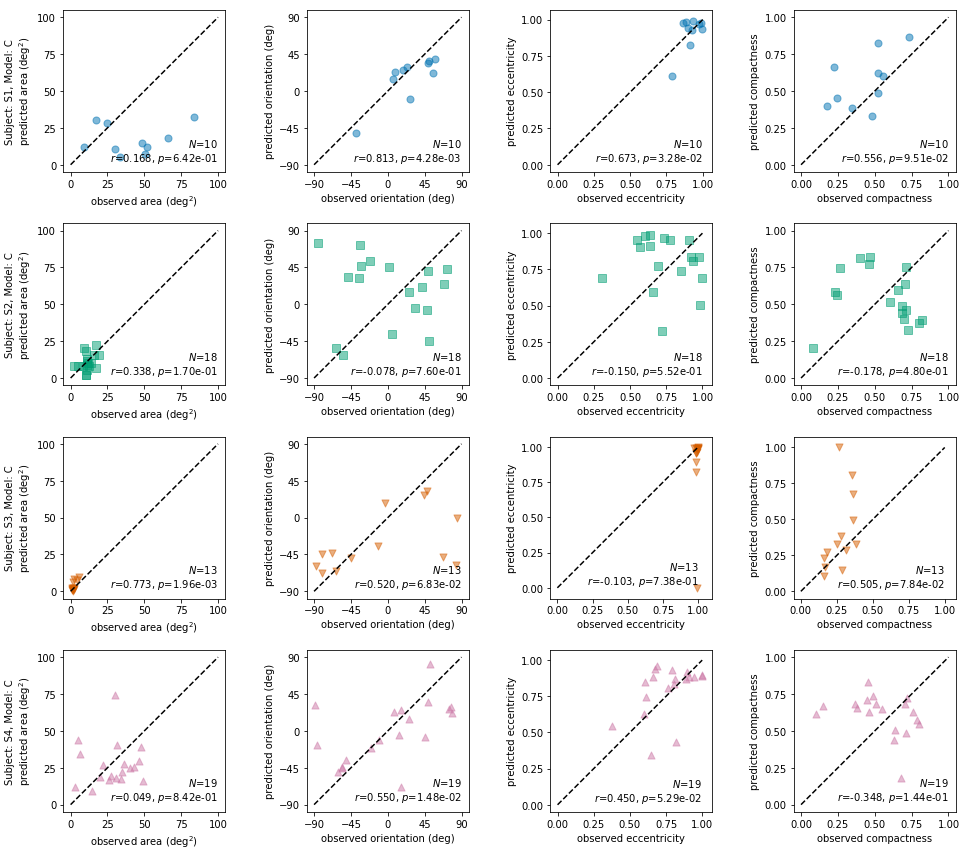

In [15]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 100], [-90, 90], [0, 1], [0, 1]]
limits = [[-10, 110], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.png' % plotmodel)